# Apprentissage Supervisé - Classification

*Lorenzo Brucato - Alexandre Loret*
___

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# fonctions pour la regression
from ClfFunctions import *

## 1. Chargement, pré traitement des données et visualisation

**Jeu de données complet :**

In [7]:
train = pd.read_csv("data/train.csv").drop(['Unnamed: 0'], axis=1) # jeu de données d'entrainement
test = pd.read_csv("data/test.csv").drop(["row_ID"],axis=1)

In [9]:
n, p = train.shape
print(n, p) # 100000 données d'entrainement pour 55 variables

100000 55


**Sous jeu de données équilibré pour l'analyse :**

In [12]:
from sklearn.utils import shuffle 

rs = 42
size_by_cover = 200
train_indexs = []

for cover_type in range(1, 8):
    train_indexs += list(train[train['Cover_Type'] == cover_type][:size_by_cover].index)

In [14]:
sub_train = shuffle(train.iloc[train_indexs].reset_index(drop=True), random_state = rs).reset_index(drop=True)
sub_train

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0          2172     115     36                               153   
1          2046      91     26                                30   
2          2962      83     18                               108   
3          2305     145     19                               134   
4          3166     163     12                               577   
...         ...     ...    ...                               ...   
1395       2489      70      7                               534   
1396       2584     306     20                                60   
1397       3390     144     13                               134   
1398       2746     328     12                                60   
1399       2514     119      6                                30   

      Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                 94                              658   
1                                 13                              532   
2                                 27                             1559   
3                                 31                              124   
4                                 99                             2692   
...                              ...                              ...   
1395                              85                              553   
1396                              16                             1273   
1397                              32                             4279   
1398                               8                             1991   
1399                               4                              297   

      Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0               253             179             20   
1               249             189             52   
2               242             206             88   
3               243             233            111   
4               231             243            141   
...             ...             ...            ...   
1395            228             226            132   
1396            162             224            201   
1397            238             237            127   
1398            192             226            174   
1399            231             235            137   

      Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                     67  ...            0            0   
1                                    626  ...            0            0   
2                                   3434  ...            0            0   
3                                    875  ...            0            0   
4                                   3055  ...            1            0   
...                                  ...  ...          ...          ...   
1395                                1008  ...            0            0   
1396                                 792  ...            0            1   
1397                                4039  ...            0            1   
1398                                 684  ...            0            0   
1399                                1616  ...            0            0   

      Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0               0            0            0            0            0   
1               0            0            0            0            0   
2               0            0            0            0            0   
3               0            0            0            0            0   
4               0            0            0            0            0   
...           ...          ...          ...          ...          ...   
1395            0            0            0            0            0   
1396            0            0            0            0            0   
1397            0            0            0            0            0   
1398            0            0  

### 1.1 Valeurs manquantes

Pas de valeurs manquantes dans les données :

In [18]:
print(pd.isna(train).sum().sum())
print(pd.isna(test).sum().sum())

0
0


In [20]:
train.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

### 1.2 Features engineering

**Description des variables :**

*Variables explicatives :* 
- `Elevation` : elevation en mètres
- `Aspect` : aspect (en degrés azimuth)
- `Slope` : degré de pente (en degré)
- `Horizontal_Distance_To_Hydrology` : distance horizontale à la source d'eau la plus proche
- `Vertical_Distance_To_Hydrology` : distance vertical à la source d'eau la plus proche
- `Horizontal_Distance_To_Roadways` : distance horizontale à la route la plus proche
- `Hillshade_9am` : ombre de relief (9h du matin)
- `Hillshade_Noon` : ombre de relief (midi)
- `Hillshade_3pm` : ombre de relief (3h de l'après-midi)
- `Horizontal_Distance_To_Fire_Points` : distance horizontale au départ d'incendie de forêt le plus porche
- `Wilderness_AreaX` : type naturel (4 modalités, 0:absence, 1:presence)
- `Soil_typeX` : type de sol (40 modalités, 0:absence, 1:presence)

*Variable cible :*
- `Cover_type` : type de forêt (7 modalités, 1:Spruce, 2:Lodgepole Pine, 3:Ponderosa Pine, 4:Cottonwood/Willow, 5:Aspen, 6:Douglas-fir, 7:Krummholz)

#### 1.2.1 Description des variables et visualisation

In [25]:
train.describe()

Elevation         Aspect          Slope  \
count  100000.000000  100000.000000  100000.000000   
mean     2959.215150     155.551260      14.122850   
std       280.832825     111.759698       7.507368   
min      1860.000000       0.000000       0.000000   
25%      2809.000000      59.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     260.000000      18.000000   
max      3858.000000     360.000000      62.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     100000.000000                   100000.000000   
mean                         269.605630                       46.821590   
std                          212.770595                       58.689319   
min                            0.000000                     -161.000000   
25%                          108.000000                        7.000000   
50%                          218.000000                       30.000000   
75%                          384.000000                       69.000000   
max                         1383.000000                      598.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    100000.000000  100000.000000   100000.000000   
mean                       2350.361130     212.103800      223.348670   
std                        1560.499103      26.841126       19.756411   
min                           0.000000       0.000000       42.000000   
25%                        1103.000000     198.000000      213.000000   
50%                        1992.000000     218.000000      226.000000   
75%                        3331.250000     231.000000      237.000000   
max                        7078.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  ...    Soil_Type32  \
count  100000.000000                       100000.000000  ...  100000.000000   
mean      142.585660                         1976.436530  ...       0.090250   
std        38.459542                         1324.925172  ...       0.286541   
min         0.000000                            0.000000  ...       0.000000   
25%       119.000000                         1020.000000  ...       0.000000   
50%       143.000000                         1704.000000  ...       0.000000   
75%       169.000000                         2549.000000  ...       0.000000   
max       254.000000                         7126.000000  ...       1.000000   

         Soil_Type33    Soil_Type34    Soil_Type35    Soil_Type36  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.079220       0.002800       0.003080       0.000200   
std         0.270083       0.052841       0.055412       0.014141   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type37    Soil_Type38    Soil_Type39    Soil_Type40  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean        0.000570       0.027890       0.024050       0.015440   
std         0.023868       0.164658       0.153205       0.123295   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Cover_Type  
count  100000.000000  
mean        2.054180  
std         1.398794  
min         1.000000  
25%         1.000000  
50%         2.000000  
75%         2.000000  
max         7.000000  

[8 rows x 55 colu

In [27]:
test.describe()

Elevation         Aspect          Slope  \
count  481012.000000  481012.000000  481012.000000   
mean     2959.396516     155.678750      14.099723   
std       279.808380     111.945819       7.484261   
min      1859.000000       0.000000       0.000000   
25%      2809.000000      58.000000       9.000000   
50%      2996.000000     127.000000      13.000000   
75%      3163.000000     261.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     481012.000000                   481012.000000   
mean                         269.391333                       46.335129   
std                          212.503535                       58.212679   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          218.000000                       29.000000   
75%                          384.000000                       69.000000   
max                         1397.000000                      601.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    481012.000000  481012.000000   481012.000000   
mean                       2350.102014     212.154832      223.312489   
std                        1558.997695      26.755075       19.771265   
min                           0.000000       0.000000        0.000000   
25%                        1106.000000     198.000000      213.000000   
50%                        1998.000000     218.000000      226.000000   
75%                        3327.000000     231.000000      237.000000   
max                        7117.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  ...    Soil_Type31  \
count  481012.000000                       481012.000000  ...  481012.000000   
mean      142.516330                         1981.092599  ...       0.044242   
std        38.235983                         1324.043373  ...       0.205633   
min         0.000000                            0.000000  ...       0.000000   
25%       119.000000                         1024.000000  ...       0.000000   
50%       143.000000                         1711.000000  ...       0.000000   
75%       168.000000                         2550.000000  ...       0.000000   
max       254.000000                         7173.000000  ...       1.000000   

         Soil_Type32    Soil_Type33    Soil_Type34    Soil_Type35  \
count  481012.000000  481012.000000  481012.000000  481012.000000   
mean        0.090422       0.077403       0.002767       0.003291   
std         0.286785       0.267231       0.052530       0.057273   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type36    Soil_Type37    Soil_Type38    Soil_Type39  \
count  481012.000000  481012.000000  481012.000000  481012.000000   
mean        0.000206       0.000501       0.026577       0.023702   
std         0.014345       0.022378       0.160845       0.152120   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type40  
count  481012.000000  
mean        0.014981  
std         0.121476  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000  

[8 rows x 54 colu

In [28]:
# features sur les types de sols
base_soil_feat = [c for c in train.columns if 'Soil_Type' in c and c != 'Soil_Type15']

# features continues
base_cont_feat = [c for c in train.columns if not('Wilderness_Area' in c or 'Soil_Type' in c or c == "Cover_Type")]

# features wilderness
base_wild_feat = [c for c in train.columns if 'Wilderness_Area' in c and c != 'Wilderness_Area2'] 

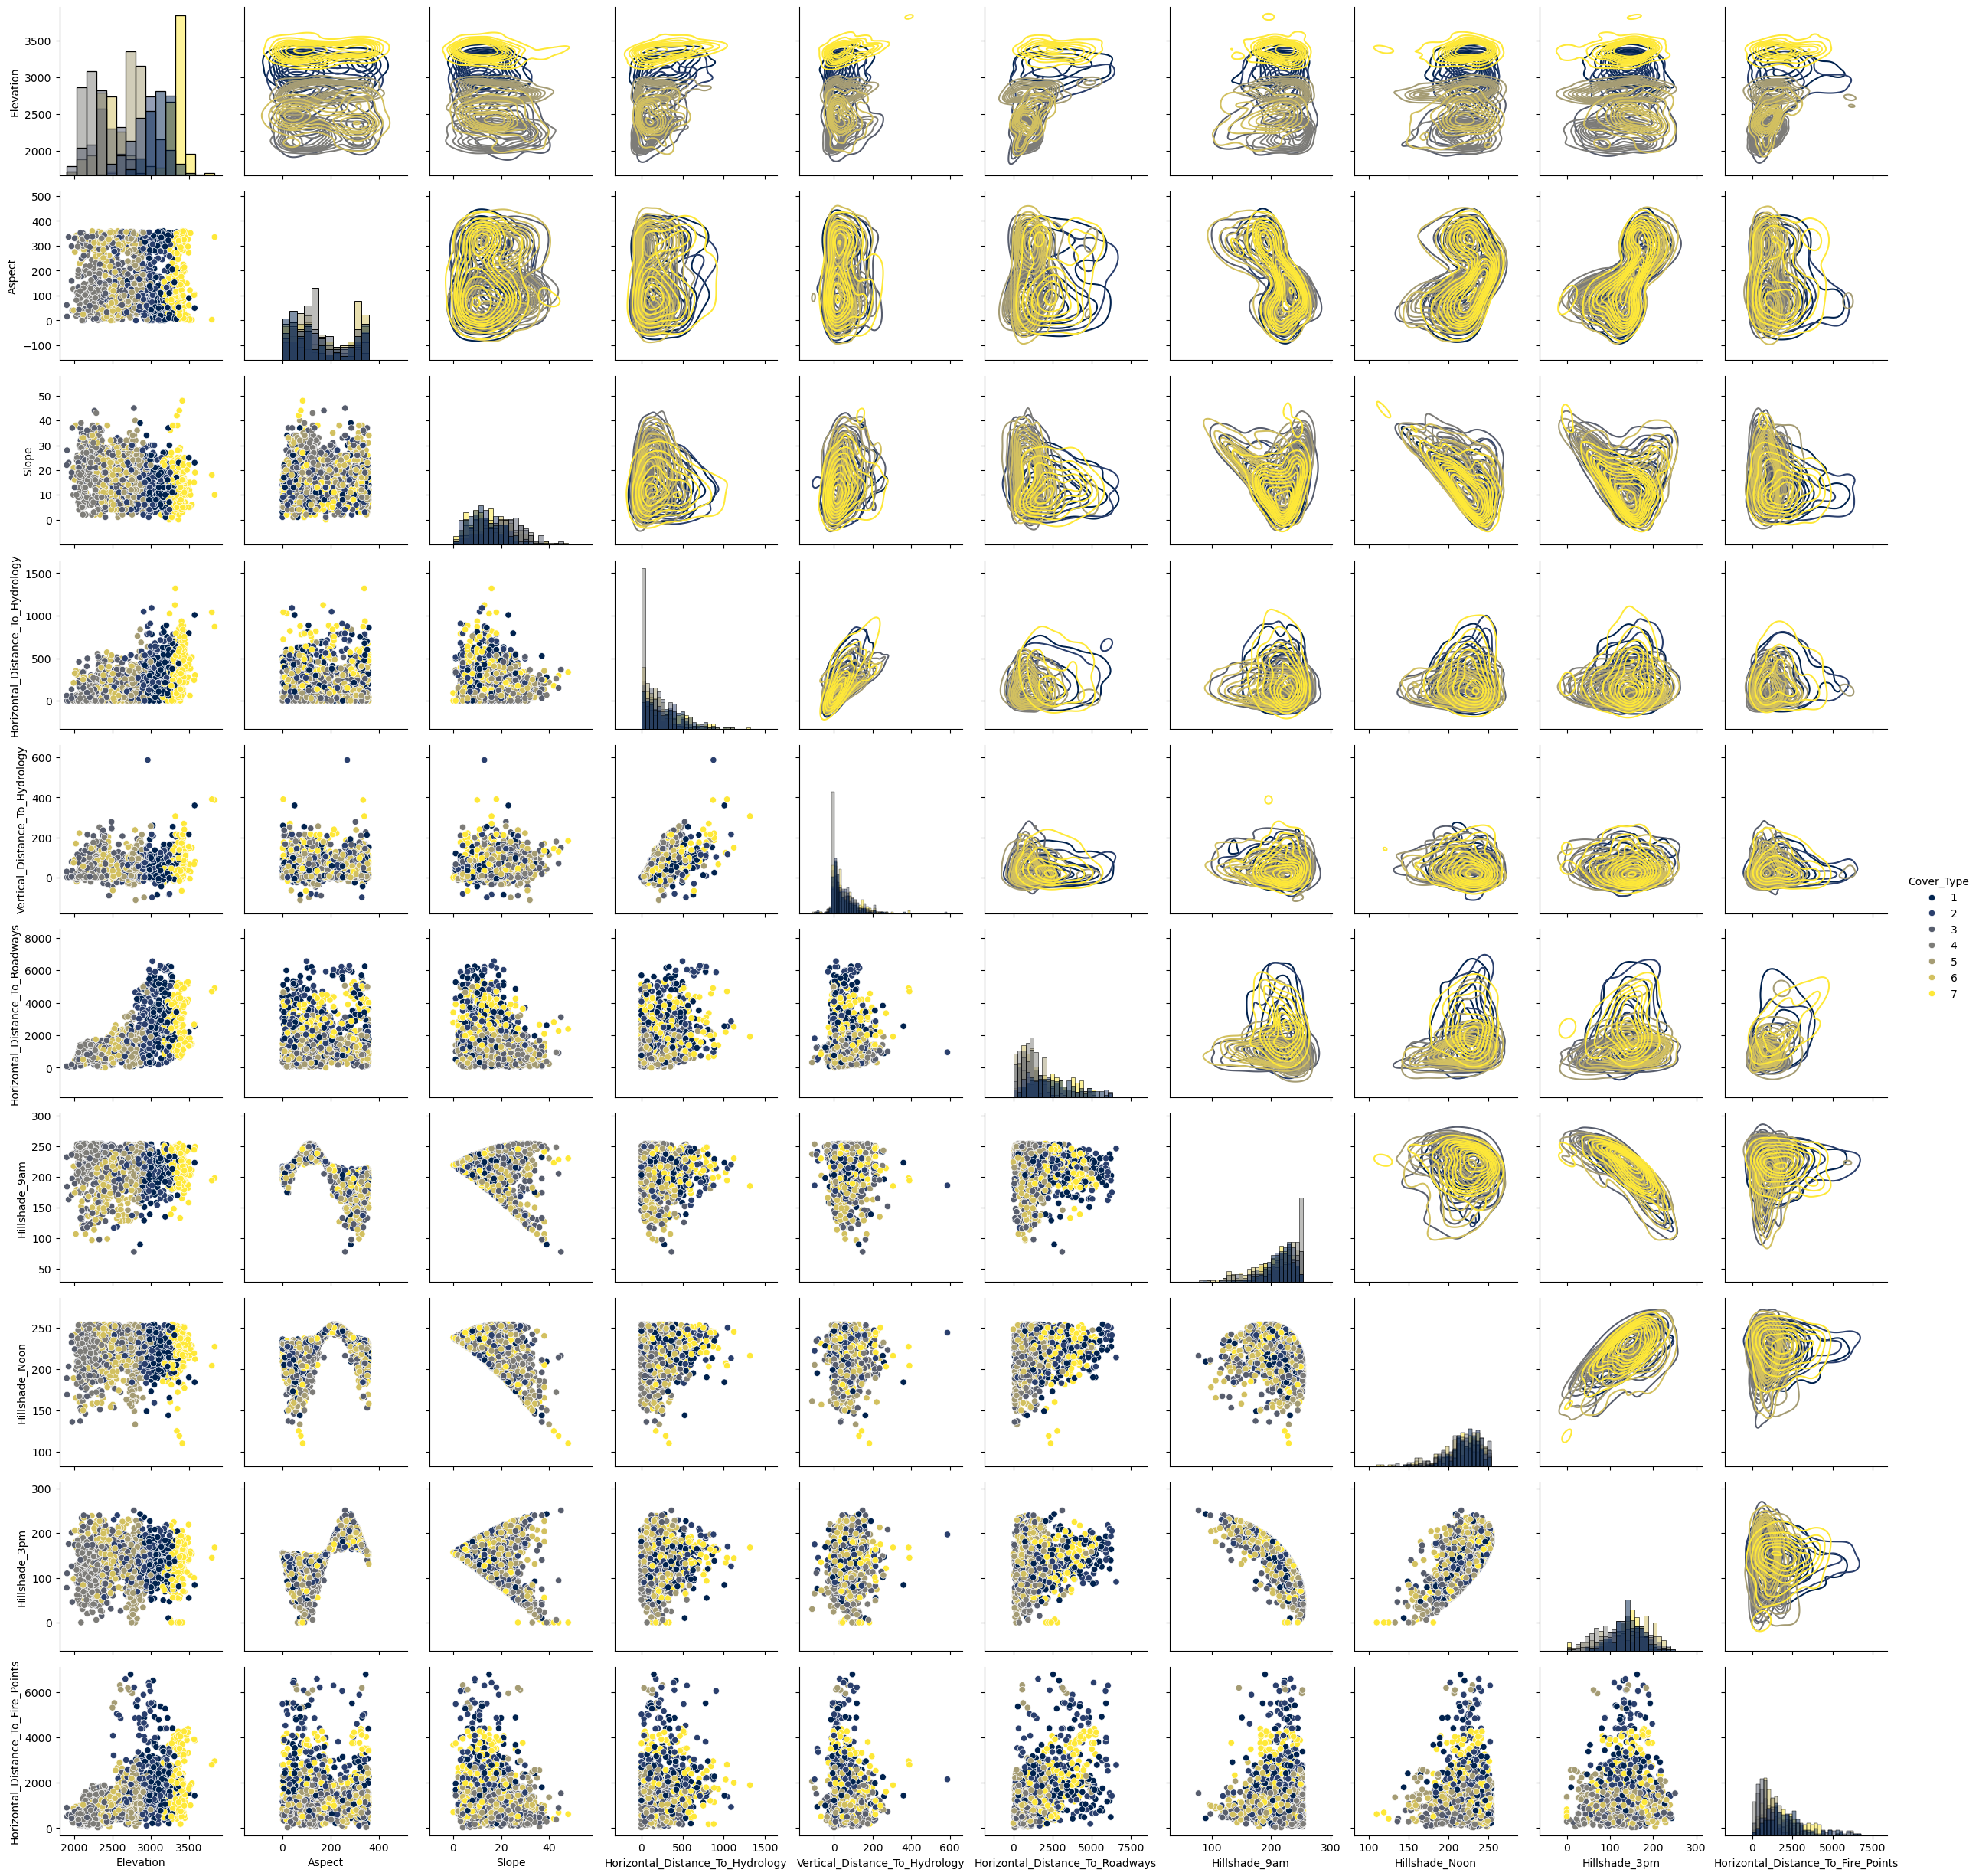

In [35]:
pg = sns.PairGrid(sub_train[base_cont_feat + ['Cover_Type']], hue='Cover_Type', palette='cividis')

pg.map_upper(sns.kdeplot) # histogrammes 2D
pg.map_diag(sns.histplot) # histogramme 1D (sur une variable)
pg.map_lower(sns.scatterplot) # scatter plot

pg.add_legend()

### 1.2.2 Features engineering

**Suppression de Soil_type15 :** qui n'apparait pas dans les données d'entrainement

In [38]:
train = train.drop('Soil_Type15', axis = 1)
test = test.drop('Soil_Type15', axis = 1)
sub_train = sub_train.drop('Soil_Type15', axis=1)

**Distances:**

On remarque sur la visualisation ci-dessus une correlation linéaire assez significative pour les données de distance notamment : 
- entre l'axe verticale et horizontale du points d'eau le plus proche
- entre la distance aux routes et la distance aux points d'incendie

On ajoute quelques variables supplémentaires :
- distance euclidienne au point d'eau le plus proche
- norme sur la route et le point d'incendie le plus proche (horizontal)
- composantes horizontales et verticales au carré

In [40]:
train['Norm_To_Hydrology'] = np.sqrt(train['Vertical_Distance_To_Hydrology']**2 + train['Horizontal_Distance_To_Hydrology']**2)
test['Norm_To_Hydrology'] = np.sqrt(test['Vertical_Distance_To_Hydrology']**2 + test['Horizontal_Distance_To_Hydrology']**2)
sub_train['Norm_To_Hydrology'] = np.sqrt(sub_train['Vertical_Distance_To_Hydrology']**2 + sub_train['Horizontal_Distance_To_Hydrology']**2)

train['Norm_Fire_Road'] = np.sqrt(train['Horizontal_Distance_To_Roadways']**2 + train['Horizontal_Distance_To_Fire_Points']**2)
test['Norm_Fire_Road'] = np.sqrt(test['Horizontal_Distance_To_Roadways']**2 + test['Horizontal_Distance_To_Fire_Points']**2)
sub_train['Norm_Fire_Road'] = np.sqrt(sub_train['Horizontal_Distance_To_Roadways']**2 + sub_train['Horizontal_Distance_To_Fire_Points']**2)

In [41]:
train['Vertical_Distance_To_Hydrology2'] = train['Vertical_Distance_To_Hydrology']**2
test['Vertical_Distance_To_Hydrology2'] = test['Vertical_Distance_To_Hydrology']**2 
sub_train['Vertical_Distance_To_Hydrology2'] = sub_train['Vertical_Distance_To_Hydrology']**2

train['Horizontal_Distance_To_Hydrology2'] = train['Horizontal_Distance_To_Hydrology']**2
test['Horizontal_Distance_To_Hydrology2'] = test['Horizontal_Distance_To_Hydrology']**2 
sub_train['Horizontal_Distance_To_Hydrology2'] = sub_train['Horizontal_Distance_To_Hydrology']**2

train['Horizontal_Distance_To_Fire_Points2'] = train['Horizontal_Distance_To_Fire_Points']**2
test['Horizontal_Distance_To_Fire_Points2'] = test['Horizontal_Distance_To_Fire_Points']**2 
sub_train['Horizontal_Distance_To_Fire_Points2'] = sub_train['Horizontal_Distance_To_Fire_Points']**2

train['Horizontal_Distance_To_Roadways2'] = train['Horizontal_Distance_To_Roadways']**2
test['Horizontal_Distance_To_Roadways2'] = test['Horizontal_Distance_To_Roadways']**2 
sub_train['Horizontal_Distance_To_Roadways2'] = sub_train['Horizontal_Distance_To_Roadways']**2

**Caractéristiques sur l'évolution du Hillshade:**

In [43]:
# différence de hilshade au carré
train['Hillshade_DiffN9'] = (train['Hillshade_Noon'] - train['Hillshade_9am'])**2
test['Hillshade_DiffN9'] = (test['Hillshade_Noon'] - test['Hillshade_9am'])**2
sub_train['Hillshade_DiffN9'] = (sub_train['Hillshade_Noon'] - sub_train['Hillshade_9am'])**2

train['Hillshade_Diff39'] = (train['Hillshade_3pm'] - train['Hillshade_9am'])**2
test['Hillshade_Diff39'] = (test['Hillshade_3pm'] - test['Hillshade_9am'])**2
sub_train['Hillshade_Diff39'] = (sub_train['Hillshade_3pm'] - sub_train['Hillshade_9am'])**2

# distance à l'origine (possiblement intéressant en visualisant le scatterplot)
train['Hillshade_NormN9'] = np.sqrt(train['Hillshade_Noon']**2 + train['Hillshade_9am']**2)
test['Hillshade_NormN9'] = np.sqrt(test['Hillshade_Noon']**2 + test['Hillshade_9am']**2)
sub_train['Hillshade_NormN9'] = np.sqrt(sub_train['Hillshade_Noon']**2 + sub_train['Hillshade_9am']**2)

train['Hillshade_Norm39'] = np.sqrt(train['Hillshade_3pm']**2 + train['Hillshade_9am']**2)
test['Hillshade_Norm39'] = np.sqrt(test['Hillshade_3pm']**2 + test['Hillshade_9am']**2)
sub_train['Hillshade_Norm39'] = np.sqrt(sub_train['Hillshade_3pm']**2 + sub_train['Hillshade_9am']**2)

**Cosinus/Sinus des angles  :** 

In [45]:
train['Aspect_Cos'] = np.cos(train['Aspect']*(2*np.pi/360))
test['Aspect_Cos'] = np.cos(test['Aspect']*(2*np.pi/360))
sub_train['Aspect_Cos'] = np.cos(sub_train['Aspect']*(2*np.pi/360))

train['Slope_Cos'] = np.cos(train['Slope']*(2*np.pi/360))
test['Slope_Cos'] = np.cos(test['Slope']*(2*np.pi/360))
sub_train['Slope_Cos'] = np.cos(sub_train['Slope']*(2*np.pi/360))


train['Aspect_Sin'] = np.sin(train['Aspect']*(2*np.pi/360))
test['Aspect_Sin'] = np.sin(test['Aspect']*(2*np.pi/360))
sub_train['Aspect_Sin'] = np.sin(sub_train['Aspect']*(2*np.pi/360))

train['Slope_Sin'] = np.sin(train['Slope']*(2*np.pi/360))
test['Slope_Sin'] = np.sin(test['Slope']*(2*np.pi/360))
sub_train['Slope_Sin'] = np.sin(sub_train['Slope']*(2*np.pi/360))

**Suppression d'une colonne Wilderness pour préserver l'identifiabilité :**

In [47]:
train = train.drop('Wilderness_Area2', axis=1)
test = test.drop('Wilderness_Area2', axis=1)
sub_train = sub_train.drop('Wilderness_Area2', axis=1)

*mise à jour des features :*

In [49]:
# features sur les types de sols
soil_feat = [c for c in train.columns if 'Soil_Type' in c and c != 'Soil_Type15']

# features continues
cont_feat = [c for c in train.columns if not('Wilderness_Area' in c or 'Soil_Type' in c or c == "Cover_Type")]

# features wilderness
wild_feat = [c for c in train.columns if 'Wilderness_Area' in c] 

**Matrices de correlation :**

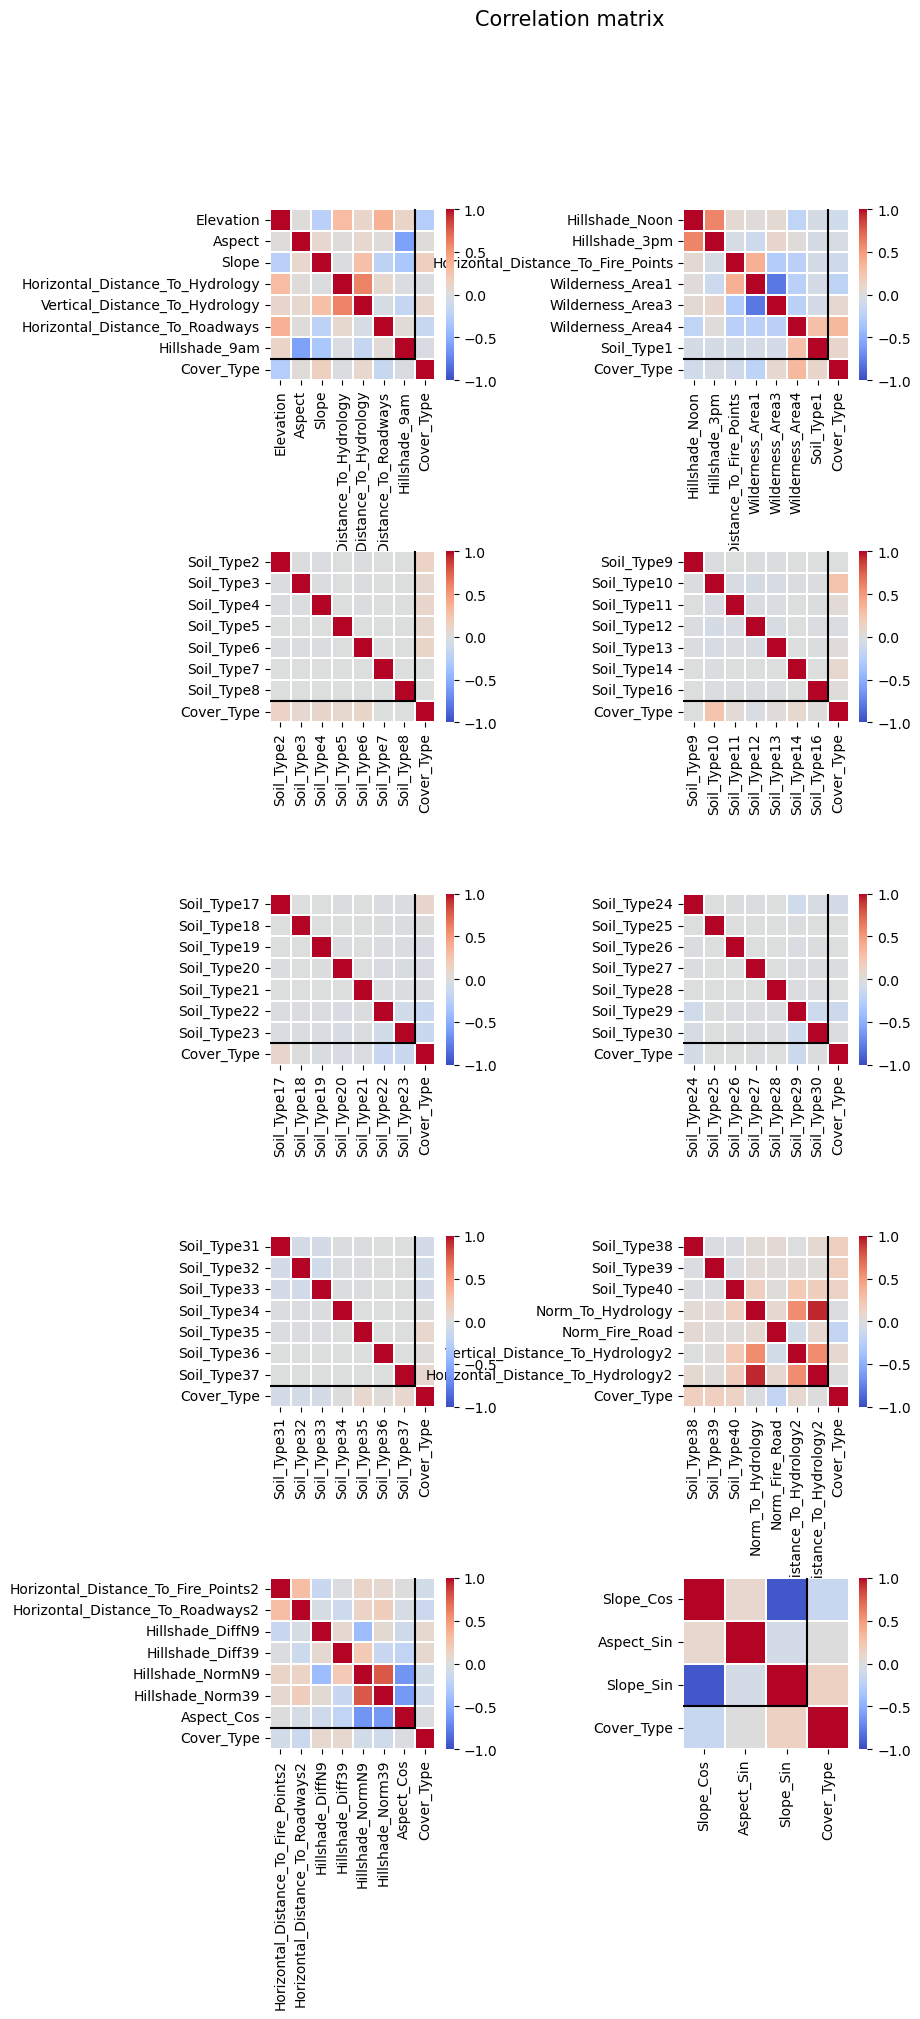

In [59]:
corrplot(train, 'Cover_Type')

#### 1.2.3 Distribution de la classe cible, création d'un jeu de données plus équilibré

(array([36410., 48676.,  6273.,   471.,  1635.,  2967.,  3568.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <BarContainer object of 7 artists>)

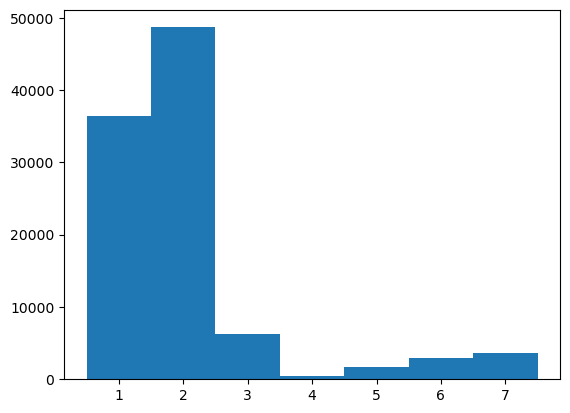

In [91]:
plt.hist(train['Cover_Type'], bins=[.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5])

In [94]:
size = []
for i in range(1,8):
    size.append(len(train.loc[train['Cover_Type'] == i]))
size

[36410, 48676, 6273, 471, 1635, 2967, 3568]

On remarque que les données sont très déséquilibrées avec les classes 3, 4, 5, 6 et 7 qui sont très peu représentées en comparaison des classes majoritaires 1 et 2.
On décide de réequilibrer légèrement les données en générant des donnée pour des classes minoritaires (oversampling) selon les tailles d'échantillons suivantes (on veut en particulier conserver une majorité de données réelles pour ne pas apporter trop de biais sur les modèles/scores en validation croisée). On utilise la librairie imblearn et la fonction 'SMOTE' qui propose de créer de nouveaux points en interpolant entre les points des données connues pour chaque classe :

In [97]:
from imblearn.over_sampling import SMOTE

random_state = 42

smote = SMOTE(
    random_state=random_state,
    sampling_strategy = {
        3:10000,
        4:1500,
        5:5000,
        6:5000,
        7:5000
    }
)

train_eq = pd.concat(smote.fit_resample(train.drop('Cover_Type', axis=1), train['Cover_Type']), axis=1)

(array([36410., 48676., 10000.,  1500.,  5000.,  5000.,  5000.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <BarContainer object of 7 artists>)

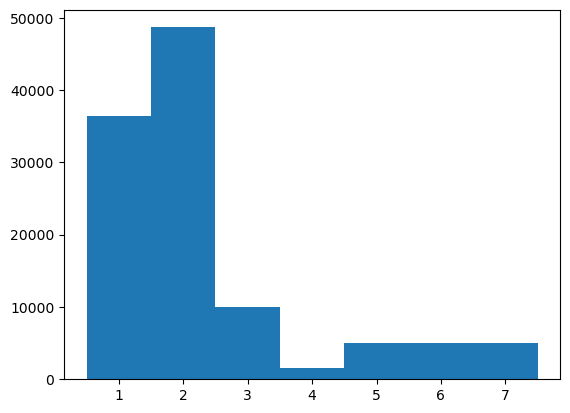

In [99]:
plt.hist(train_eq['Cover_Type'], bins = [(i-.5) for i in range(1,9)])

In [154]:
print("Taux de données réelles : ", train.shape[0]/train_eq.shape[0])

Taux de données réelles :  0.8961697704013049


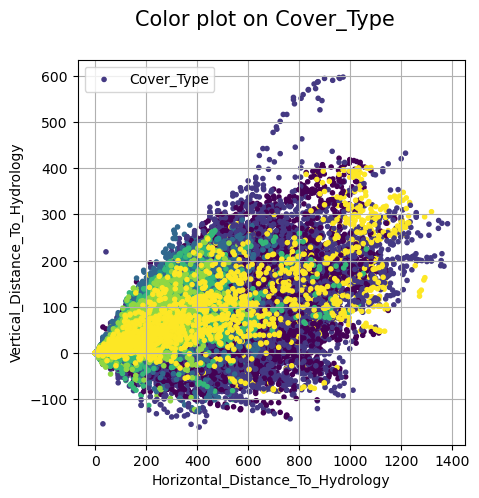

In [101]:
colorScatterPlot('Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Cover_Type', train_eq)

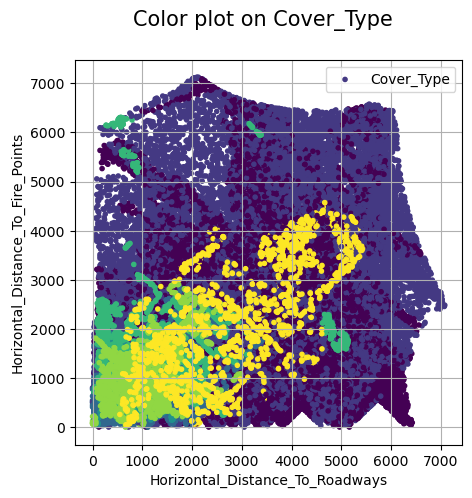

In [102]:
colorScatterPlot('Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Cover_Type', train_eq)

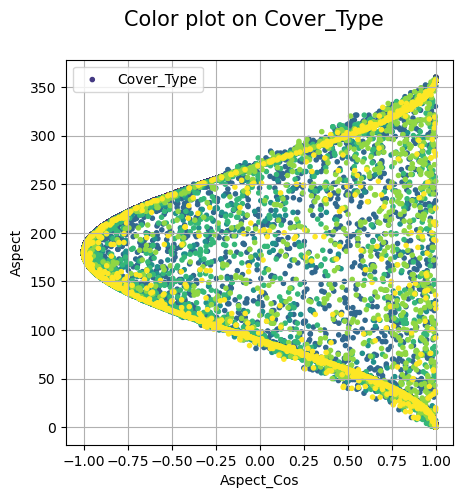

In [103]:
colorScatterPlot('Aspect_Cos', 'Aspect', 'Cover_Type', train_eq)

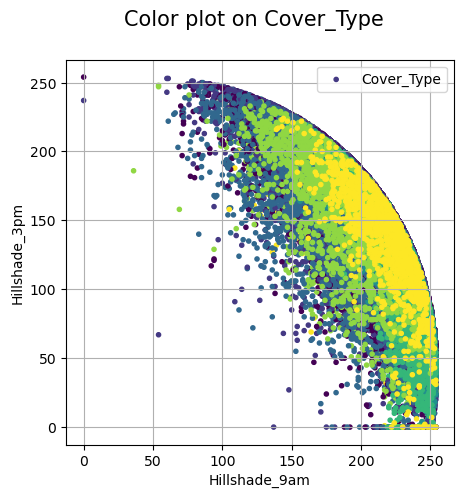

In [104]:
colorScatterPlot('Hillshade_9am', 'Hillshade_3pm', 'Cover_Type', train_eq)

## 2. Inférence

La partie 1 met à disposition trois jeux de données : 
- Jeu de données originales : `train`
- Jeu de données légèrement rééquilibré : `train_eq`
- Jeu de données original réduit en dimension : `train_red`

**Métriques de mesure de performance et recherche d'hyperparamètres par validation croisée :**

In [68]:
# recherche d'hyperparamètres par validation croisée
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler

scoring = {
    'f1_weighted': make_scorer(f1_score, greater_is_better=True, average='weighted'),
    'f1_macro': make_scorer(f1_score, greater_is_better=True, average='macro'),
}

scaler = StandardScaler()

### 2.1 Regression logistique

La regression logistique sert ici principalement de référence pour comparer la performance des autres modèles plus gourmands. Elle permet également d'observer l'influence du traitement des données sur les résultats :

*Données originales :* 

In [72]:
Xtrain, Ytrain = train.drop('Cover_Type', axis=1)[base_cont_feat + base_soil_feat + base_wild_feat], train['Cover_Type']
Xtest = test.copy()

In [74]:
from sklearn.linear_model import LogisticRegression

LogitModel = LogisticRegression(max_iter=1000)

Logit_CV = GridSearchAnalysis(LogitModel, scaler.fit_transform(Xtrain), Ytrain, scoring)

In [76]:
Logit_CV.score_table()

fit_time    f1_weighted       f1_macro
0  2.717 ± 0.183  0.716 ± 0.003  0.530 ± 0.006

*Données augmentées :* 

In [79]:
Xtrain, Ytrain = train.drop('Cover_Type', axis=1), train['Cover_Type']
Xtest = test.copy()

In [81]:
from sklearn.linear_model import LogisticRegression

LogitModel = LogisticRegression(max_iter=1000)

Logit_CV = GridSearchAnalysis(LogitModel, scaler.fit_transform(Xtrain), Ytrain, scoring)

In [83]:
Logit_CV.score_table()

fit_time    f1_weighted       f1_macro
0  5.445 ± 0.455  0.729 ± 0.002  0.564 ± 0.008

*Oversampling :*

In [109]:
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type']
Xtest = test.copy()

In [111]:
from sklearn.linear_model import LogisticRegression

LogitModel = LogisticRegression(max_iter=1000)

Logit_CV = GridSearchAnalysis(LogitModel, scaler.fit_transform(Xtrain), Ytrain, scoring)

In [113]:
Logit_CV.score_table()

fit_time    f1_weighted       f1_macro
0  7.675 ± 1.070  0.728 ± 0.023  0.681 ± 0.056

### 2.2 Arbre de décision

In [ ]:
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type']
Xtest = test.copy()

In [119]:
from sklearn.tree import DecisionTreeClassifier

TreeModel = DecisionTreeClassifier()

param_grid = {
    "max_depth":[10,30,50,70,100]
}

Tree_CV = GridSearchAnalysis(TreeModel, Xtrain, Ytrain, scoring, param_grid=param_grid)

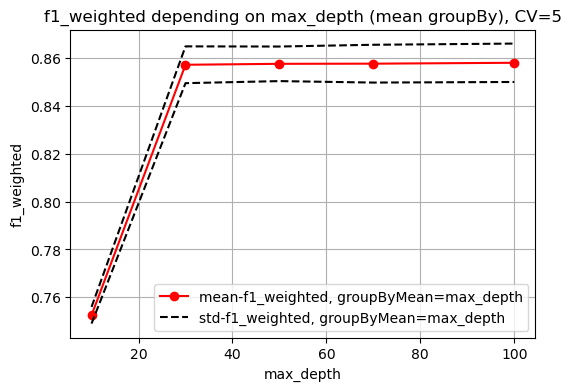

In [121]:
Tree_CV.plot_score(groupBy='max_depth')

In [123]:
Tree_CV.score_table()

max_depth       fit_time    f1_weighted       f1_macro
0         10  1.184 ± 0.022  0.752 ± 0.003  0.704 ± 0.005
1         30  2.228 ± 0.036  0.857 ± 0.008  0.853 ± 0.016
2         50  2.250 ± 0.114  0.858 ± 0.007  0.853 ± 0.016
3         70  2.172 ± 0.019  0.858 ± 0.008  0.853 ± 0.015
4        100  2.165 ± 0.021  0.858 ± 0.008  0.854 ± 0.016

In [125]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

TreeModel = DecisionTreeClassifier(max_depth=30)
TreeModel.fit(Xtrain, Ytrain)

print(export_text(TreeModel,feature_names=test.columns,max_depth=3))

|--- Elevation <= 3042.50
|   |--- Elevation <= 2573.50
|   |   |--- Wilderness_Area1 <= 0.50
|   |   |   |--- Horizontal_Distance_To_Hydrology <= 29.50
|   |   |   |   |--- truncated branch of depth 20
|   |   |   |--- Horizontal_Distance_To_Hydrology >  29.50
|   |   |   |   |--- truncated branch of depth 27
|   |   |--- Wilderness_Area1 >  0.50
|   |   |   |--- Horizontal_Distance_To_Fire_Points2 <= 26621040.00
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- Horizontal_Distance_To_Fire_Points2 >  26621040.00
|   |   |   |   |--- truncated branch of depth 5
|   |--- Elevation >  2573.50
|   |   |--- Elevation <= 2902.50
|   |   |   |--- Horizontal_Distance_To_Roadways <= 359.50
|   |   |   |   |--- truncated branch of depth 17
|   |   |   |--- Horizontal_Distance_To_Roadways >  359.50
|   |   |   |   |--- truncated branch of depth 27
|   |   |--- Elevation >  2902.50
|   |   |   |--- Norm_To_Hydrology <= 95.87
|   |   |   |   |--- truncated branch of depth 25
|   | 

### 2.3 Random Forest

*Données originales :*

In [155]:
Xtrain, Ytrain = train.drop('Cover_Type', axis=1)[base_cont_feat + base_soil_feat + base_wild_feat], train['Cover_Type']

In [157]:
from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier(class_weight='balanced')

param_grid = {
    
    'n_estimators': [30],                      # Nombre d'arbres dans la forêt
    'max_depth': [35, 40, 45, 50, 55, 60],     # Profondeur maximale de l'arbre
    'bootstrap':[False]             # bootstrapping des échantillons --> on a ici beacoup de données accessibles : le bootstrap dégrade les résultats
 
}

RF_CV1 = GridSearchAnalysis(RFModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [161]:
RF_CV1.score_table()

n_estimators  max_depth  bootstrap       fit_time    f1_weighted  \
0            30         35      False  5.196 ± 0.104  0.909 ± 0.001   
1            30         40      False  5.157 ± 0.181  0.909 ± 0.002   
2            30         45      False  5.175 ± 0.089  0.908 ± 0.002   
3            30         50      False  5.324 ± 0.045  0.909 ± 0.001   
4            30         55      False  5.250 ± 0.126  0.909 ± 0.002   
5            30         60      False  5.173 ± 0.069  0.909 ± 0.001   

        f1_macro  
0  0.849 ± 0.006  
1  0.847 ± 0.004  
2  0.846 ± 0.005  
3  0.848 ± 0.005  
4  0.850 ± 0.003  
5  0.847 ± 0.005

*Données augmentées :*

In [164]:
Xtrain, Ytrain = train.drop('Cover_Type', axis=1), train['Cover_Type']

In [166]:
from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier(class_weight='balanced')

param_grid = {
    
    'n_estimators': [30],                      # Nombre d'arbres dans la forêt
    'max_depth': [35, 40, 45, 50, 55, 60],     # Profondeur maximale de l'arbre
    'bootstrap':[False]             # bootstrapping des échantillons --> on a ici beacoup de données accessibles : le bootstrap dégrade les résultats
 
}

RF_CV2 = GridSearchAnalysis(RFModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [168]:
RF_CV2.score_table()

n_estimators  max_depth  bootstrap       fit_time    f1_weighted  \
0            30         35      False  8.754 ± 0.171  0.915 ± 0.003   
1            30         40      False  8.861 ± 0.270  0.915 ± 0.002   
2            30         45      False  9.489 ± 0.250  0.916 ± 0.002   
3            30         50      False  9.568 ± 0.148  0.914 ± 0.002   
4            30         55      False  9.369 ± 0.111  0.915 ± 0.001   
5            30         60      False  9.569 ± 0.210  0.914 ± 0.001   

        f1_macro  
0  0.853 ± 0.003  
1  0.854 ± 0.003  
2  0.854 ± 0.004  
3  0.853 ± 0.005  
4  0.854 ± 0.005  
5  0.851 ± 0.006

*Oversampling :*

In [171]:
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type']

In [173]:
from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier(class_weight='balanced')

param_grid = {
    
    'n_estimators': [30],                      # Nombre d'arbres dans la forêt
    'max_depth': [35, 40, 45, 50, 55, 60],     # Profondeur maximale de l'arbre
    'bootstrap':[False]             # bootstrapping des échantillons --> on a ici beacoup de données accessibles : le bootstrap dégrade les résultats
 
}

RF_CV3 = GridSearchAnalysis(RFModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [175]:
RF_CV3.score_table()

n_estimators  max_depth  bootstrap        fit_time    f1_weighted  \
0            30         35      False  10.142 ± 0.059  0.925 ± 0.007   
1            30         40      False  10.203 ± 0.133  0.925 ± 0.008   
2            30         45      False  10.884 ± 0.546  0.925 ± 0.008   
3            30         50      False  11.062 ± 0.241  0.925 ± 0.008   
4            30         55      False  10.930 ± 0.106  0.925 ± 0.007   
5            30         60      False  11.278 ± 0.274  0.925 ± 0.009   

        f1_macro  
0  0.925 ± 0.016  
1  0.925 ± 0.017  
2  0.925 ± 0.016  
3  0.924 ± 0.016  
4  0.925 ± 0.017  
5  0.925 ± 0.017

*Sélection de variables par importance :*

In [177]:
RFModel = RandomForestClassifier(max_depth = 45, n_estimators = 200, bootstrap=False, class_weight='balanced')

RFModel.fit(scaler.fit_transform(Xtrain), Ytrain)

importances = RFModel.feature_importances_
feature_names = Xtrain.columns

# Créer un DataFrame pour l'importance des variables
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

In [217]:
keep_features = list(feature_importances.loc[feature_importances['importance'] >= 0.001, 'feature'])
sup = ['Horizontal_Distance_To_Hydrology2', 'Vertical_Distance_To_Hydrology', 'Aspect_Sin', 'Slope', 'Hillshade_DiffN9']
keep_features = [c for c in keep_features if not(c in sup)]

In [219]:
RFModel = RandomForestClassifier(class_weight='balanced')

param_grid = {
    
    'n_estimators': [50],                  # Nombre d'arbres dans la forêt
    'max_depth': [40, 45],             # Profondeur maximale de l'arbre
    'bootstrap':[False]                    # bootstrapping des échantillons
 
}

RF_CV4 = GridSearchAnalysis(RFModel, scaler.fit_transform(Xtrain[list(keep_features)]), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [221]:
RF_CV4.score_table()

n_estimators  max_depth  bootstrap        fit_time    f1_weighted  \
0            50         40      False  16.935 ± 0.140  0.932 ± 0.007   
1            50         45      False  17.145 ± 0.398  0.931 ± 0.007   

        f1_macro  
0  0.931 ± 0.015  
1  0.930 ± 0.015

In [ ]:
RFModel = RandomForestClassifier()

param_grid = {
    
    'n_estimators': [50],                            # Nombre d'arbres dans la forêt
    'max_depth': [45],                               # Profondeur maximale de l'arbre
    'bootstrap':[False]                               # bootstrapping des échantillons
 
}

RF_CV2 = GridSearchAnalysis(RFModel, scaler.fit_transform(Xtrain[list(keep_features)]), Ytrain, scoring, param_grid=param_grid, n_folds=5)

### 2.4 Boosting

*Données originales :*

In [ ]:
Xtrain, Ytrain = train.drop('Cover_Type', axis=1)[base_cont_feat + base_soil_feat + base_wild_feat], train['Cover_Type']

In [ ]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier()

param_grid = {
    'n_estimators':[250, 300],
    'learning_rate':[0.5, 1.0],
    'max_depth':[7, 10, 15, 20]
}

XGB_CV = GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

*Oversampling :*

In [146]:
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type'] - 1

In [174]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier()

param_grid = {
    'n_estimators':[300, 350],
    'learning_rate':[0.5],
    'max_depth':[10, 15, 20]
}

XGB_CV = GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [177]:
XGB_CV.score_table()

n_estimators  learning_rate  max_depth        fit_time    f1_weighted  \
0           300            0.5         10  11.564 ± 0.345  0.936 ± 0.008   
1           350            0.5         10  12.862 ± 0.188  0.937 ± 0.008   
2           300            0.5         15  12.627 ± 0.128  0.938 ± 0.007   
3           350            0.5         15  15.769 ± 0.945  0.939 ± 0.007   
4           300            0.5         20  15.032 ± 0.839  0.939 ± 0.007   
5           350            0.5         20  16.244 ± 0.772  0.938 ± 0.007   

        f1_macro  
0  0.938 ± 0.017  
1  0.938 ± 0.017  
2  0.940 ± 0.017  
3  0.940 ± 0.017  
4  0.940 ± 0.016  
5  0.940 ± 0.017

In [188]:
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type'] - 1

XGBModel = xgb.XGBClassifier(n_etsimators = 300, learning_rate=0.5, max_depth=20)

XGBModel.fit(scaler.fit_transform(Xtrain), Ytrain)

In [212]:
feature_importances = pd.DataFrame({
    'variable':Xtrain.columns,
    'importance':XGBModel.feature_importances_
}).sort_values(by='importance', ascending=False)
feature_importances

variable  importance
48       Soil_Type37    0.080734
24       Soil_Type12    0.059106
46       Soil_Type35    0.057132
16        Soil_Type4    0.056596
14        Soil_Type2    0.055188
..               ...         ...
59  Hillshade_Diff39    0.002691
61  Hillshade_Norm39    0.002536
58  Hillshade_DiffN9    0.002376
65         Slope_Sin    0.002301
19        Soil_Type7    0.000000

[66 rows x 2 columns]

*Selection de variables par importance : (> 0.004)*

In [325]:
keep_features = list(feature_importances.loc[feature_importances['importance'] >= 0.004, 'variable'])
print(len(keep_features))
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1)[keep_features], train_eq['Cover_Type'] - 1

56


In [293]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier()

param_grid = {
    'n_estimators':[300],
    'learning_rate':[0.5],
    'max_depth':[20]
}

XGB_CV1 = GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [295]:
XGB_CV1.score_table()

n_estimators  learning_rate  max_depth        fit_time    f1_weighted  \
0           300            0.5         20  13.401 ± 0.852  0.941 ± 0.006   

        f1_macro  
0  0.943 ± 0.013

In [342]:
feature_importances

variable  importance
48       Soil_Type37    0.080734
24       Soil_Type12    0.059106
46       Soil_Type35    0.057132
16        Soil_Type4    0.056596
14        Soil_Type2    0.055188
..               ...         ...
59  Hillshade_Diff39    0.002691
61  Hillshade_Norm39    0.002536
58  Hillshade_DiffN9    0.002376
65         Slope_Sin    0.002301
19        Soil_Type7    0.000000

[66 rows x 2 columns]

*Selection de variables par improtance : (> 0.003)*

In [351]:
keep_features = list(feature_importances.loc[feature_importances['importance'] >= 0.003, 'variable'])
print(len(keep_features))
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1)[keep_features], train_eq['Cover_Type'] - 1

58


In [353]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier()

param_grid = {
    'n_estimators':[300],
    'learning_rate':[0.5],
    'max_depth':[20]
}

XGB_CV2 = GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [354]:
XGB_CV2.score_table()

n_estimators  learning_rate  max_depth        fit_time    f1_weighted  \
0           300            0.5         20  13.480 ± 0.631  0.942 ± 0.006   

        f1_macro  
0  0.943 ± 0.013

*Selection de variables par importance : (> 0.003) et suppression de quelques variables corrélées à des variables de plus grande importance*

In [191]:
keep_features = list(feature_importances.loc[feature_importances['importance'] >= 0.003, 'variable'])
keep_features = [c for c in keep_features if not(c in ['Horizontal_Distance_To_Roadways', 'Vertical_Distance_To_Hydrology2', 'Hillshade_3pm', 'Horizontal_Distance_To_Hydrology2', 'Aspect'])]
print(keep_features)
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1)[keep_features], train_eq['Cover_Type'] - 1

NameError: name 'feature_importances' is not defined

In [193]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier()

param_grid = {
    'n_estimators':[300],
    'learning_rate':[0.5, 1.0],
    'max_depth':[5]
}

XGB_CV3= GridSearchAnalysis(XGBModel, scaler.fit_transform(Xtrain), Ytrain, scoring, param_grid=param_grid, n_folds=5)

In [195]:
XGB_CV3.score_table()

n_estimators  learning_rate  max_depth       fit_time    f1_weighted  \
0           300            0.5          5  4.750 ± 0.053  0.910 ± 0.007   
1           300            1.0          5  5.035 ± 0.312  0.919 ± 0.007   

        f1_macro  
0  0.925 ± 0.015  
1  0.929 ± 0.014

## 3. Soumissions

**1) Regression logistique : public score = 0.66102**

In [133]:
from sklearn.linear_model import LogisticRegression

# données originales
Xtrain, Ytrain = train.drop('Cover_Type', axis=1)[base_cont_feat + base_soil_feat + base_wild_feat], train['Cover_Type']
Xtest = test[base_cont_feat + base_soil_feat + base_wild_feat]

LogitModel = LogisticRegression(max_iter=1000)

LogitModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = LogitModel.predict(scaler.transform(Xtest)) 

submit_model('reg_logistique', Ypred, test)

**2) Arbre de décision : public score = 0.86933**

In [135]:
from sklearn.tree import DecisionTreeClassifier

# données originales
Xtrain, Ytrain = train.drop('Cover_Type', axis=1)[base_cont_feat + base_soil_feat + base_wild_feat], train['Cover_Type']
Xtest = test[base_cont_feat + base_soil_feat + base_wild_feat]

TreeModel = DecisionTreeClassifier(max_depth=30)

TreeModel.fit(Xtrain, Ytrain)

Ypred = TreeModel.predict(Xtest) 

submit_model('tree', Ypred, test)

**3) Random Forest, jeu de données avec surechantillonage, augmentation des variables et selection par importance : public score = 0.9327**

In [140]:
from sklearn.ensemble import RandomForestClassifier

keep_features = ['Elevation','Norm_Fire_Road', 'Horizontal_Distance_To_Roadways2','Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Fire_Points2','Wilderness_Area4','Norm_To_Hydrology',
 'Horizontal_Distance_To_Hydrology','Hillshade_NormN9','Aspect_Cos','Hillshade_9am',
 'Vertical_Distance_To_Hydrology2','Wilderness_Area1','Hillshade_Norm39','Hillshade_Diff39','Aspect',
 'Hillshade_3pm','Hillshade_Noon','Soil_Type38','Soil_Type10','Soil_Type39','Wilderness_Area3','Slope_Cos',
 'Slope_Sin','Soil_Type3','Soil_Type4','Soil_Type40','Soil_Type22','Soil_Type30','Soil_Type29','Soil_Type2','Soil_Type23',
 'Soil_Type12','Soil_Type32','Soil_Type33','Soil_Type13','Soil_Type31','Soil_Type6','Soil_Type24','Soil_Type11','Soil_Type17','Soil_Type35'
]

# données augmentées avec surechantillonage
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1)[keep_features], train_eq['Cover_Type'] - 1
Xtest = test[keep_features]

RFModel = RandomForestClassifier(max_depth = 40, n_estimators = 200, bootstrap=False, class_weight='balanced') # meilleurs hyperparamètres par gridsearch

RFModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = RFModel.predict(scaler.transform(Xtest))

submit_model('rf', Ypred, test)

**4) Boosting, données avec surechantillonage, première version sans sélection de variables, 300 estimateurs, profondeur=20, lr=0.5 : public score = 0.93753**

In [144]:
import xgboost as xgb

# données augmentées avec surechantillonage
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1), train_eq['Cover_Type'] - 1
Xtest = test

XGBModel = xgb.XGBClassifier(n_estimators = 300, learning_rate=0.5, max_depth=20)

XGBModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = XGBModel.predict(scaler.transform(Xtest)) + 1

submit_model('boost', Ypred, test)

**5) Boosting, données avec surechantillonage, sélection de variable, mêmes hyperparamètres que précédemment : public score = 0.94116**

In [186]:
import xgboost as xgb

keep_features = ['Soil_Type37', 'Soil_Type12', 'Soil_Type35', 
 'Soil_Type4', 'Soil_Type2', 'Soil_Type22', 
 'Soil_Type39', 'Wilderness_Area1', 'Elevation', 
 'Soil_Type38', 'Soil_Type32', 'Soil_Type31', 'Soil_Type23', 
 'Wilderness_Area4', 'Soil_Type26', 'Wilderness_Area3', 
 'Soil_Type17', 'Soil_Type27', 'Soil_Type11', 'Soil_Type25', 
 'Soil_Type5', 'Soil_Type10', 'Soil_Type33', 'Soil_Type36', 
 'Soil_Type3', 'Soil_Type9', 'Soil_Type24', 'Soil_Type13', 
 'Soil_Type20', 'Soil_Type40', 'Soil_Type30', 'Soil_Type21', 
 'Soil_Type29', 'Soil_Type34', 'Horizontal_Distance_To_Roadways2', 
 'Soil_Type28', 'Soil_Type6', 'Norm_Fire_Road', 'Soil_Type16', 'Soil_Type14', 
 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 
 'Aspect_Cos', 'Horizontal_Distance_To_Fire_Points2', 'Soil_Type18', 
 'Hillshade_Noon', 'Hillshade_9am', 'Soil_Type19', 'Hillshade_NormN9', 
 'Norm_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Slope', 'Soil_Type8']

# données augmentées avec surechantillonage
Xtrain, Ytrain = train_eq.drop('Cover_Type', axis=1)[keep_features], train_eq['Cover_Type'] - 1
Xtest = test[keep_features]

XGBModel = xgb.XGBClassifier(n_estimators = 300, learning_rate=0.5, max_depth=5)

XGBModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = XGBModel.predict(scaler.transform(Xtest[keep_features])) + 1

submit_model('boost_impvar', Ypred, test)

### 4. Analyse de classification

On visualise ci-dessous la qualité des prévisions (notamment les confusions entre classes sur les différents modèles). On prend ici les données originales augmentées sans surechantillonage : 

**1) Random forest**

In [324]:
Xtrain, Ytrain = train.iloc[:80000].drop('Cover_Type', axis=1), train.iloc[:80000]['Cover_Type']
Xvalid, Yvalid = train.iloc[80000:].drop('Cover_Type', axis=1), train.iloc[80000:]['Cover_Type']

keep_features = ['Elevation','Norm_Fire_Road', 'Horizontal_Distance_To_Roadways2','Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Fire_Points2','Wilderness_Area4','Norm_To_Hydrology',
 'Horizontal_Distance_To_Hydrology','Hillshade_NormN9','Aspect_Cos','Hillshade_9am',
 'Vertical_Distance_To_Hydrology2','Wilderness_Area1','Hillshade_Norm39','Hillshade_Diff39','Aspect',
 'Hillshade_3pm','Hillshade_Noon','Soil_Type38','Soil_Type10','Soil_Type39','Wilderness_Area3','Slope_Cos',
 'Slope_Sin','Soil_Type3','Soil_Type4','Soil_Type40','Soil_Type22','Soil_Type30','Soil_Type29','Soil_Type2','Soil_Type23',
 'Soil_Type12','Soil_Type32','Soil_Type33','Soil_Type13','Soil_Type31','Soil_Type6','Soil_Type24','Soil_Type11','Soil_Type17','Soil_Type35'
]

In [326]:
from sklearn.ensemble import RandomForestClassifier

RFModel = RandomForestClassifier(max_depth = 40, n_estimators = 200, bootstrap=False, class_weight='balanced')

RFModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = RFModel.predict(scaler.transform(Xvalid))

Text(0.5, 1.0, 'Confusion Matrix - True label normalization')

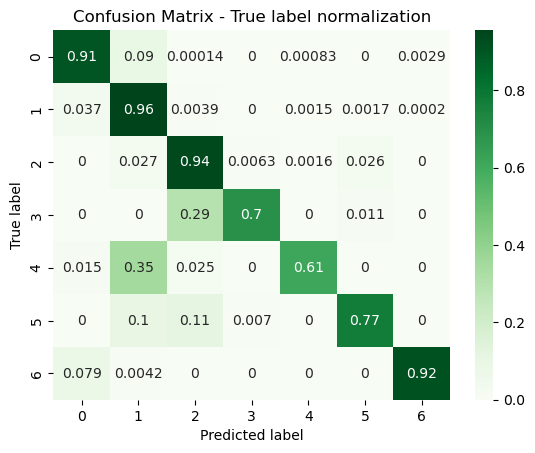

In [332]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 1)
cm = confusion_matrix(Yvalid, Ypred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens', ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confusion Matrix - True label normalization')

**2) Boosting**

In [253]:
Xtrain, Ytrain = train.iloc[:80000].drop('Cover_Type', axis=1), train.iloc[:80000]['Cover_Type'] - 1
Xvalid, Yvalid = train.iloc[80000:].drop('Cover_Type', axis=1), train.iloc[80000:]['Cover_Type']

keep_features = ['Soil_Type37', 'Soil_Type12', 'Soil_Type35', 
 'Soil_Type4', 'Soil_Type2', 'Soil_Type22', 
 'Soil_Type39', 'Wilderness_Area1', 'Elevation', 
 'Soil_Type38', 'Soil_Type32', 'Soil_Type31', 'Soil_Type23', 
 'Wilderness_Area4', 'Soil_Type26', 'Wilderness_Area3', 
 'Soil_Type17', 'Soil_Type27', 'Soil_Type11', 'Soil_Type25', 
 'Soil_Type5', 'Soil_Type10', 'Soil_Type33', 'Soil_Type36', 
 'Soil_Type3', 'Soil_Type9', 'Soil_Type24', 'Soil_Type13', 
 'Soil_Type20', 'Soil_Type40', 'Soil_Type30', 'Soil_Type21', 
 'Soil_Type29', 'Soil_Type34', 'Horizontal_Distance_To_Roadways2', 
 'Soil_Type28', 'Soil_Type6', 'Norm_Fire_Road', 'Soil_Type16', 'Soil_Type14', 
 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 
 'Aspect_Cos', 'Horizontal_Distance_To_Fire_Points2', 'Soil_Type18', 
 'Hillshade_Noon', 'Hillshade_9am', 'Soil_Type19', 'Hillshade_NormN9', 
 'Norm_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Slope', 'Soil_Type8']

In [259]:
import xgboost as xgb

XGBModel = xgb.XGBClassifier(n_estimators = 300, learning_rate=0.5, max_depth=20)

XGBModel.fit(scaler.fit_transform(Xtrain), Ytrain)

Ypred = XGBModel.predict(scaler.transform(Xvalid)) + 1

Text(0.5, 1.0, 'Confusion Matrix - True label normalization')

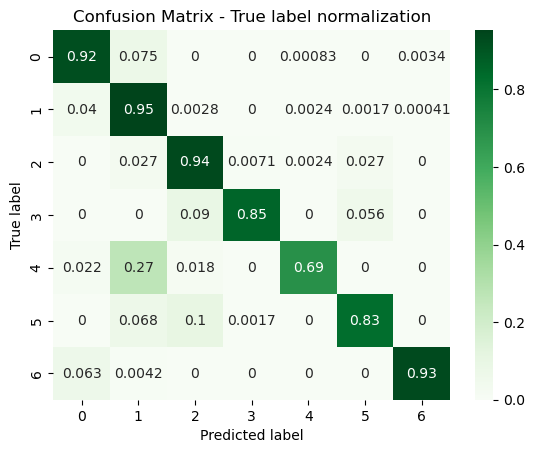

In [313]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(1, 1)
cm = confusion_matrix(Yvalid, Ypred, normalize='true')
sns.heatmap(cm, annot=True, cmap='Greens', ax=ax)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
ax.set_title('Confusion Matrix - True label normalization')

(attention décalage sur les indices de la matrice de confusion : indice 4 --> classe 5) 

On observe une meilleure performance globale du modèle de boosting. Les confusions les plus notables pour les deux modèles sont entre les éléments de la classe 5 (Aspen) souvent classifiés comme des pins (classe 2). La méthode de boosting réalise cependant moins de confusions entre les pins ponderosa et les arbres Cottonwood 